## Генерация данных

In [1]:
import scipy as sp
from scipy.stats import gamma
sp.random.seed(3)  # для воспроизведения данных в дальнейшем

x = sp.arange(1, 31*24)
y = sp.array(200*(sp.sin(2*sp.pi*x/(7*24))), dtype=int).astype(float)
y += gamma.rvs(15, loc=0, scale=100, size=len(x))
y += 2 * sp.exp(x/100.0)
y = sp.ma.array(y, mask=[y<0])
print(sum(y), sum(y<0))

sp.savetxt("data\web_traffic1.tsv", list(zip(x, y)), delimiter="\t", fmt="%s")

(1456085.8710802256, 0)


## Чтение данных

Мы собрали и агрегировали статистику веб за последний месяц, эти данные находятся в файле __"data\web_traffic.tsv"__ (расширение __tsv__ означает, что значения разделены знаками табуляции).

Данные представляют собой количество запросов в час. В каждой строке указан час (по порядку) и количество запросов за этот час.

Метод __genfromtxt()__ из библиотеки SciPy позволяет легко прочитать эти данные:

In [2]:
import scipy as sp
data = sp.genfromtxt("data\web_traffic.tsv", delimiter="\t")

Чтобы столбцы правильно распознавались, необходимо указать, что разделителем служит знак табуляции (__delimiter="\t"__).

Простая проверка показывает, что данные прочитаны верно:

In [3]:
print(data[:10])
print(data.shape)

[[  1.00000000e+00   2.27200000e+03]
 [  2.00000000e+00              nan]
 [  3.00000000e+00   1.38600000e+03]
 [  4.00000000e+00   1.36500000e+03]
 [  5.00000000e+00   1.48800000e+03]
 [  6.00000000e+00   1.33700000e+03]
 [  7.00000000e+00   1.88300000e+03]
 [  8.00000000e+00   2.28300000e+03]
 [  9.00000000e+00   1.33500000e+03]
 [  1.00000000e+01   1.02500000e+03]]
(743L, 2L)


Как видим, создан двумерный массив, содержащий 743 результата измерений.

## Предварительная обработка и очистка данных

Для SciPy удобнее представить данные в виде двух векторов длинной 743 каждый. 

Вектор __х__ будет содержать часы,
__у__ - количество запросов в течение соответствующего часа. 

Для такого разделения массива в SciPy предусмотрена специальная форма индексов, позволяющая выбирать отдельные столбцы:

In [4]:
x = data[:,0]
y = data[:,1]

Проблема в том, что в векторе у встречаются недопустимые значения - __nan__. 
Посмотрим, сколько раз встречается такое значение:

In [5]:
sp.sum(sp.isnan(y))

8

Как видим, отсутствуют всего 8 из 743 значений, так что можно спокойно удалить их. 

Напомним, что массив SciPy можно индексировать другим массивом. 

Метод __sp.isnan(y)__ возвращает массив булевых величин, показывающих, является элемент числом или нет. 
Оператор __~__ вычисляет логическое отрицание этого массива, то есть позволяет выбрать
из векторов х и у только элементы, содержащие число:

In [6]:
x = x[~sp.isnan(y)]
y = y[~sp.isnan(y)]

Чтобы составить первое представление о данных, нанесем на график диаграмму рассеяния, воспользовавшись библиотекой __matplotlib__. В этой библиотеке есть пакет __pyplot__, имитирующий интерфейс MATLAB

In [7]:
import matplotlib.pyplot as plt

# all examples will have three classes in this file
colors = ['g', 'k', 'b', 'm', 'r']
linestyles = ['-', '-.', '--', ':', '-']

def plot_models(x, y, models, mx=None, ymax=None, xmin=None):
    ''' plot input data '''

    plt.figure(num=None, figsize=(8, 6))
    plt.clf()
    plt.scatter(x, y, s=10)
    plt.title("Web traffic over the last month")
    plt.xlabel("Time")
    plt.ylabel("Hits/hour")
    plt.xticks([w * 7 * 24 for w in range(5)], 
               ['week %i' % w for w in range(5)])

    if models:
        if mx is None:
            mx = sp.linspace(0, x[-1], 1000)
        for model, style, color in zip(models, linestyles, colors):
            # print "Model:",model
            # print "Coeffs:",model.coeffs
            plt.plot(mx, model(mx), linestyle=style, linewidth=2, c=color)

        plt.legend(["d = %i" % m.order for m in models], loc="upper left")

    # plt.autoscale(tight=True)
    plt.ylim(ymin=0)
    
    if ymax:
        plt.ylim(ymax=ymax)
    if xmin:
        plt.xlim(xmin=xmin)
    plt.grid(True, linestyle='-', color='0.75')
    plt.show()

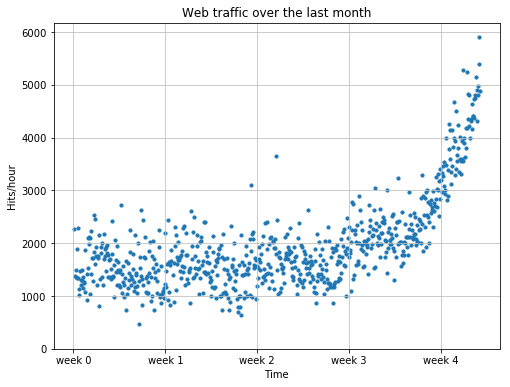

In [8]:
# first look at the data
plot_models(x, y, None)

Из графика видно, что в первые несколько недель трафик был более-менее стабильным, но в последнюю неделю наблюдался резкий рост.

## Выбор подходящей модели и обучающего алгоритма

Составив представление о данных, вернемся к исходному вопросу: как долго наш сервер сможет обслуживать входящий трафик? 
Для ответа на него нужно сделать следующее:
 1. Построить модель, отражающую зашумленные данные.
 2. С помощью этой модели экстраполировать данные на будущее и определить, в какой момент следует расширить инфраструктуру.

## Прежде чем строить модель ...

Можно считать, что модель - это упрощенное теоретическое приближение к сложной реальности. Поэтому в модели всегда существует неточность, которую называют __погрешностью аппроксимации__.
Именно величина погрешности и позволяет выбрать подходящую модель из множества возможных. Погрешность вычисляется как квадрат расстояния между реальными и предсказанными моделью данными;

если __f__ - обученная модельная функция, то погрешность равна:

In [9]:
def error(f, x, y):
    return sp.sum((f(x)-y)**2)

Векторы __х__ и __у__ содержат подготовленные ранее статистические данные о запросах.  Предполагается, что обученная модель принимает вектор и возвращает результаты в виде вектора того же размера, так что разность между результатом и вектором __у__ корректно определена.

## Начнем с прямой линии

Предположим ненадолго, что данные можно смоделировать прямой линией. Тогда наша задача - найти такую прямую, для которой погрешность аппроксимации минимальна. Именно это и делает
функция __polyfit()__. 

Получив на входе векторы __х__, __у__ и требуемую степень полинома (для прямой линии степень равна 1), она находит модельную функцию, которая минимизирует определенную выше функцию погрешности:

In [10]:
fp1, residuals, rank, sv, rcond = sp.polyfit (x, y, 1, full=True)

Функция __polyfit()__ возвращает параметры подобранной модельной функции __fpl__. Если задать __full = True__, то мы получим дополнительную информацию. Нас из нее интересуют только __невязки__, которые и описывают погрешность аппроксимации:

In [11]:
print("Параметры модели: %s" % fp1)

Параметры модели: [   2.59619213  989.02487106]


In [12]:
print(residuals)

[  3.17389767e+08]


Это означает, что наилучшую линейную аппроксимацию дает следующая функция:
$$ f(x) = 2.59619213 \cdot х + 989.02487106.$$

Затем мы воспользуемся функцией __poly1d()__ о для построения модельной функции по параметрам модели:

In [13]:
f1 = sp.poly1d(fp1)
print(error(f1, x, y))

317389767.34


Мы задали __full = True__, чтобы получить детали процесса поиска аппроксимации. Обычно этого не делают, и тогда возвращаются только параметры модели.

Теперь мы можем нанести на график функцию __f1()__ и посмотреть на свою первую обученную модель:

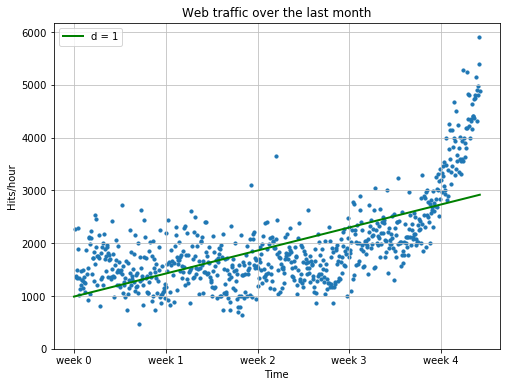

In [14]:
plot_models(x, y, [f1])

Сразу видно, что наше исходное предположение о линейности модели плохо вяжется с реальной картиной. И потом: погрешность __317 389 767.34__ - это хорошо или плохо?

Абсолютная величина погрешности редко бывает полезна сама по себе. Но если сравнить две конкурирующие модели, то на основании погрешности можно судить, какая из них лучше. И хотя мы безусловно не станем пользоваться своей первой моделью, в общей последовательности
действий она играет важную роль. __Она станет эталоном__, с которым будут сравниваться другие модели.

## В поисках лучшего решения

Попробуем теперь усложнить модель, взяв __полином степени 2__. Быть может, она сможет лучше отразить наши данные.

In [15]:
fp2 = sp.polyfit(x, y, 2)
print(fp2)

[  1.05322215e-02  -5.26545650e+00   1.97476082e+03]


In [16]:
f2 = sp.poly1d(fp2)
print(error(f2, x, y))

179983507.878


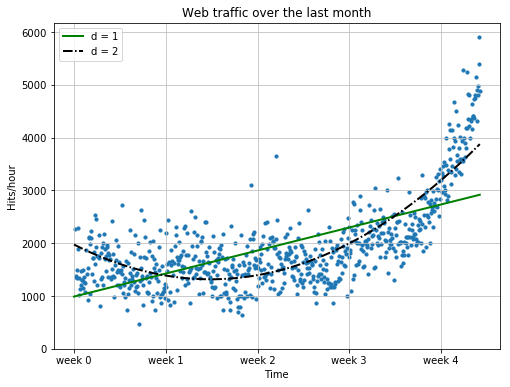

In [17]:
plot_models(x, y, [f1, f2])

Погрешность составляет __179 983 507.878__, почти вдвое меньше погрешности линейной модели. Это хорошо, но дается не даром: функция стала сложнее, а значит, __polyfit()__ должна вычислять один дополнительный параметр. 

Аппроксимирующий полином теперь выглядит так:
$$f(x) = 0.0105322215 \cdot х^2 - 5.26545650 \cdot х + 1974.76082$$

Но если усложнение функции улучшает результаты, то почему не
пойти по этому пути дальше? Попробуем степени 3, 10 и 100:

In [18]:
f3 = sp.poly1d(sp.polyfit(x, y, 3))
f10 = sp.poly1d(sp.polyfit(x, y, 10))
f100 = sp.poly1d(sp.polyfit(x, y, 100))

E:\Python\Anaconda2\lib\site-packages\numpy\lib\polynomial.py:587: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
E:\Python\Anaconda2\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


Многочисленные сообщения означают, что из-за погрешностей при вычислениях __polyfit__ не
смогла найти аппроксимирующий полином степени 100 и сочла, что степени 53 вполне достаточно.

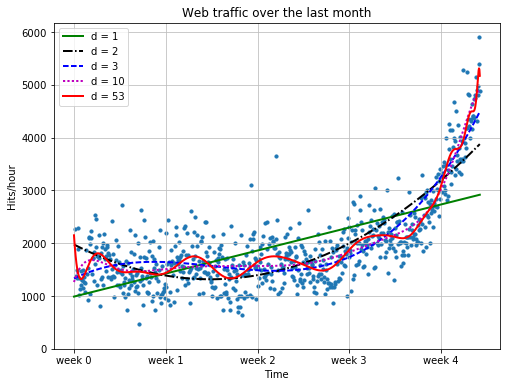

In [19]:
plot_models(x, y, [f1, f2, f3, f10, f100])

Похоже, что чем лучше кривая аппроксимирует данные, тем она сложнее. О точности аппроксимации говорят вычисленные погрешности:

In [20]:
print("Errors for the complete data set:")
for f in [f1, f2, f3, f10, f100]:
    print("Error d=%i: %f" % (f.order, error(f, x, y)))

Errors for the complete data set:
Error d=1: 317389767.339778
Error d=2: 179983507.878179
Error d=3: 139350144.031725
Error d=10: 121942326.363547
Error d=53: 109452394.562394


Но внимательно приглядевшись к аппроксимирующим кривым, мы начинаем сомневаться в том, что они действительно описывают процесс, порождающий данные. Иначе говоря, правильно ли наша модель представляет групповое поведение пользователей, посещающих наш сайт? Для полиномов степени 10 и 53 характерны резкие колебания. Складывается впечатление, что модель слишком уж близко
повторяет наблюдаемые данные. Настолько близко, что улавливает не только истинный процесс, но и шум. Этот феномен называется __переобучением__

Придя к такому выводу, мы можем выбрать один из следующих путей:

• выбрать какую-то аппроксимирующую полиномиальную модель;

• перейти на более сложные модели, например, сплайновые;

• переосмыслить данные и начать все сначала.

Из пяти исследованных моделей линейная слишком проста, а модели степени 10 и 53 переобучены. Лишь полиномы второй и третьей степени более-менее соответствуют данным. Но если экстраполировать их в обе стороны, то поведение становится ни с чем не сообразным.

Переход на дpyroй класс моделей - более сложных - тоже не кажется шагом в правильном направлении. 

Похоже, мы не до конца понимаем природу наших данных.

## Другой взгляд на данные

Взглянем на данные еще раз. Между третьей и четвертой неделей наблюдается явный изгиб. Так давайте __разделим данные__ и обучим две прямые линии, взяв в качестве точки раздела неделю 3,5:

In [21]:
inflection = int(3.5*7*24)    # вычислить положение точки изгиба в часах

xa = x[:inflection]           # данные до точки изгиба
ya = y[:inflection]

xb = x[inflection:]           # данные после нее
yb = y[inflection:]

In [22]:
fa = sp.poly1d(sp.polyfit(xa, ya, 1))
fb = sp.poly1d(sp.polyfit(xb, yb, 1))

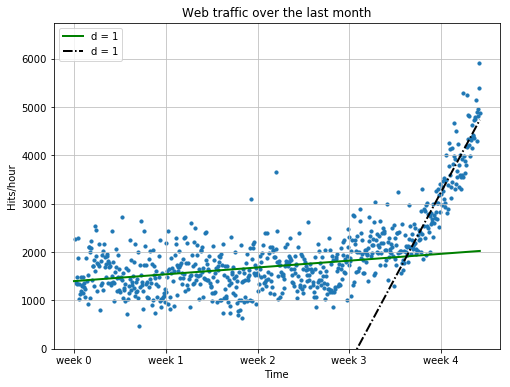

In [23]:
plot_models(x, y, [fa, fb])

In [24]:
fa_error = error(fa, xa, ya)
fb_error = error(fb, xb, yb)
print("Error inflection = %f" % (fa_error + fb_error))

Error inflection = 132950348.197616


Первую прямую мы обучаем на данных до точки изгиба, а вторую - на оставшихся.
Очевидно, что такая комбинация двух прямых аппроксимирует данные гораздо лучше, чем любая из рассмотренных выше моделей.
Тем не менее, погрешность больше, чем в случае полиномов высокой степени. Так можно ли вообще доверять погрешности?

Иначе говоря, почему прямой, аппроксимирующей только данные за последние полторы недели, мы доверяем больше, чем более сложным моделям? Потому что полагаем, что она лучше аппроксимирует
будущие данные. Если продолжить график в будущее, то будет видно, правы ли мы

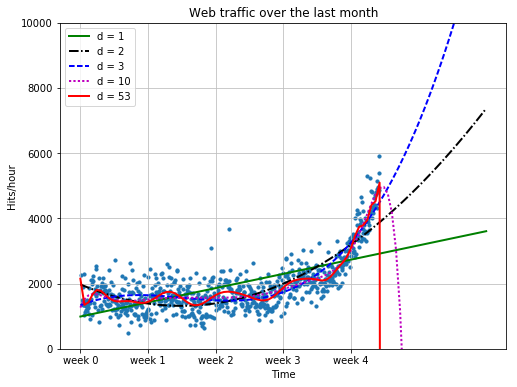

In [25]:
# extrapolating into the future
plot_models(x, y, [f1, f2, f3, f10, f100],
    mx=sp.linspace(0*7*24, 6*7*24, 100),
    ymax=10000, xmin= 0*7*24)

Модели степени 10 и 53, похоже, не обещают нашему стартапу радужное будущее. Они так стремились как можно лучше соответствовать уже имеющимся данным, что оказались совершенно непригодны для экстраполяции. Это __переобучение__. С другой стороны, модели небольших степеней недостаточно хорошо улавливают характер данных. Это называется __недообучением__.

Но давайте будем справедливы к моделям степени 2 и выше и посмотрим, как они поведут себя, если обучить их только на данных за последние полторы недели. Ведь мы исходим из того, что __данные за последний период больше говорят о будущем, чем предшествующие данные__. 

In [26]:
print("Trained only on data after inflection point")
fb1 = fb
fb2 = sp.poly1d(sp.polyfit(xb, yb, 2))
fb3 = sp.poly1d(sp.polyfit(xb, yb, 3))
fb10 = sp.poly1d(sp.polyfit(xb, yb, 10))
fb100 = sp.poly1d(sp.polyfit(xb, yb, 100))

Trained only on data after inflection point


E:\Python\Anaconda2\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
E:\Python\Anaconda2\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


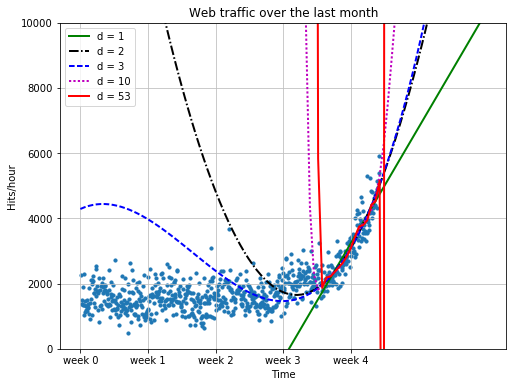

In [27]:
plot_models(x, y, [fb1, fb2, fb3, fb10, fb100],
    mx=sp.linspace(0*7*24, 6*7*24, 100),
    ymax=10000, xmin=0*7*24)

И все же, опираясь на погрешности моделей, обученных только на данных за последние полторы недели, мы должны были бы выбрать самую сложную (отметим, что и погрешность вычисляется только за период времени после точки изгиба):

In [28]:
print("Errors for only the time after inflection point")
for f in [fb1, fb2, fb3, fb10, fb100]:
    print("Error d=%i: %f" % (f.order, error(f, xb, yb)))

Errors for only the time after inflection point
Error d=1: 22143941.107618
Error d=2: 19768846.989176
Error d=3: 19766452.361027
Error d=10: 18949296.507208
Error d=53: 18300725.818669


## Обучение и тестирование

Если бы у нас были какие-то будущие данные, на которых можно было бы проверить модель, то мы смогли бы оценить выбор модели, опираясь на одну лишь результирующую погрешность аппроксимации.

__Но хотя нам не дано заглянуть в будущее, мы можем и даже должны имитировать его__, зарезервировав часть имеющихся данных. К примеру, удалим какой-то процент данных и обучим модель на оставшихся. А затем воспользуемся отложенными в сторонку данными для вычисления погрешности. Поскольку обученная модель ничего не знает о зарезервированных данных, то мы сможем составить более реалистичную картину ее поведения в будущем.

In [29]:
# separating training from testing data
frac = 0.3
split_idx = int(frac * len(xb))
shuffled = sp.random.permutation(list(range(len(xb))))   # перемешивать

test = sorted(shuffled[:split_idx])     # индексы проверочной выборки
train = sorted(shuffled[split_idx:])    # индексы обучающей выборки

fbt1 = sp.poly1d(sp.polyfit(xb[train], yb[train], 1))
fbt2 = sp.poly1d(sp.polyfit(xb[train], yb[train], 2))

print("fbt2(x)= %s\n" % str(fbt1).replace('\n', '').strip())
print("fbt2(x)-100,000= %s\n" % str(fbt2-100000).replace('\n', '').strip())

fbt3 = sp.poly1d(sp.polyfit(xb[train], yb[train], 3))
fbt10 = sp.poly1d(sp.polyfit(xb[train], yb[train], 10))
fbt100 = sp.poly1d(sp.polyfit(xb[train], yb[train], 100))

fbt2(x)= 22.15 x - 1.162e+04

fbt2(x)-100,000= 20.05405 x - 50.41 x - 8.737e+04



E:\Python\Anaconda2\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
E:\Python\Anaconda2\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


Погрешности для моделей, обученных только на данных после точки изгиба, дают совершенно иную картину:

In [30]:
print("Test errors for only the time after inflection point")
for f in [fbt1, fbt2, fbt3, fbt10, fbt100]:
    print("Error d=%i: %f" % (f.order, error(f, xb[test], yb[test])))

Test errors for only the time after inflection point
Error d=1: 6493169.692951
Error d=2: 5009473.307250
Error d=3: 5007820.965265
Error d=10: 5443168.201186
Error d=53: 5372302.441759


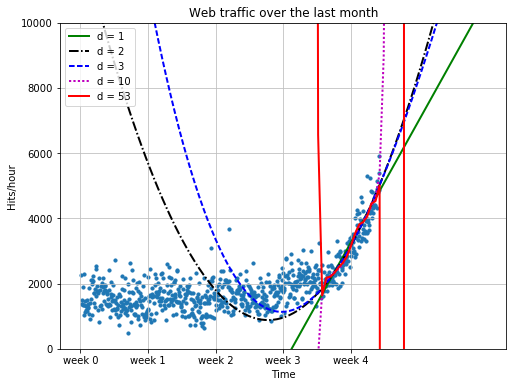

In [31]:
plot_models(x, y, [fbt1, fbt2, fbt3, fbt10, fbt100],
    mx=sp.linspace(0*7*24, 6*7*24, 100),
    ymax=10000, xmin=0*7* 24)

Вот теперь, похоже, __победитель окончательно определился__: у модели степени 2 наименьшая погрешность на тестовых данных, то есть на тех данных, которые не предъявлялись во время обучения. И это дает надежду, что ее поведение на будущих данных не станет сюрпризом.

## Ответ на первоначальный вопрос

__Наконец мы нашли модель, которая, как нам кажется, наилучшим образом описывает истинный процесс__; теперь нетрудно определить, когда мы выйдем на уровень 100 000 запросов в час. Нужно лишь вычислить, когда модельная функция принимает значение 100 000.

Для полинома степени 2 мы можем __просто найти обратную функцию__ и вычислить ее значение в точке 100 000. Но, конечно, хотелось бы уметь решать эту задачу для любой модельной функции.

Для этого достаточно вычесть из полинома 100 000 и найти корни нового полинома. В модуле SciPy __optimize__ имеется функция __fsolve__, решающая эту задачу, ей нужно только указать, начальную позицию с помощью параметра __х0__. Поскольку любая точка в нашем файле данных
соответствует одном часу, а всего имеется 743 точки, в качестве начальной позиции зададим какое-то значение, большее максимума.

Пусть __fbt2__ - полином-победитель степени 2.

In [32]:
print("fbt2(x)= %s\n" % str(fbt1).replace('\n', '').strip())
print("fbt2(x)-100,000= %s\n" % str(fbt2-100000).replace('\n', '').strip())

fbt2(x)= 22.15 x - 1.162e+04

fbt2(x)-100,000= 20.05405 x - 50.41 x - 8.737e+04



In [33]:
from scipy.optimize import fsolve
reached_max = fsolve(fbt2 - 100000, x0=800) / (7 * 24)
print("100,000 hits/hour expected at week %f" % reached_max[0])

100,000 hits/hour expected at week 10.836343


Таким образом, мы ожидаем выхода на уровень 100 000 запросов/час в неделю __9.616071__, то есть наша модель предсказывает, что если нынешнее поведение пользователей сохранится и компания не утратит привлекательности, то до насыщения текущей пропускной способности остается еще месяц.

__Конечно, этот прогноз не вполне достоверен.__ Для получения более реалистичной картины можно было бы собрать дополнительные статистические данные, которые позволили бы вычислить ожидаемую дисперсию при заглядывании во все более отдаленное будущее.

Ну и кроме того, мы не можем построить точную модель динамики поведения пользователей. Однако на данный момент прогноз нас удовлетворяет. В конце концов, __он дает возможность__ заранее предпринять требующие времени действия. Если еще и пристально следить за трафиком, то мы сможем вовремя понять, когда заказывать дополнительные ресурсы.

## Резюме

Как видно из представленного примера __при решении типичных задач машинного обучения основное время уходит на то, чтобы понять и улучшить данные__. Необходимо мысленно перенести акцент с алгоритмов на данные. А также важно правильно поставить эксперимент и не смешивать обучающие и тестовые данные.